#Variational Autoencoder (VAE) for MNIST Digit Classification

**Introduction**

This notebook guides you through building a Variational Autoencoder (VAE) for feature extraction and classification of handwritten digits. VAEs are powerful generative models that learn to encode data into a compact latent representation and then decode it back. The learned latent space can be used for various downstream tasks, such as classification.
In this assignment, you will:

- Load and preprocess the MNIST dataset
- Build a VAE architecture with encoder and decoder networks
- Train the VAE to learn meaningful latent representations
- Use the latent space to train a classifier for digit recognition
- Process your own handwritten digit images and classify them using your model

This project demonstrates how unsupervised learning (VAE) can be combined with supervised learning (classification) to create powerful machine learning pipelines.

In [1]:
# Import necessary libraries for numerical operations, deep learning, visualization and image processing
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from PIL import Image
import io


**Data Preprocessing & Loading MNIST**

We first load the MNIST dataset and normalize the images. Later, we define a function to convert an uploaded photo into an MNIST-style image (grayscale, 28×28, normalized).

In [2]:
# Load the MNIST dataset which contains 60,000 training and 10,000 test images of handwritten digits
# The dataset also includes the corresponding labels (actual digits 0-9)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the images:
# 1. Add a channel dimension (converting from shape (28, 28) to (28, 28, 1))
# 2. Convert from integer values (0-255) to floating point (0-1) by normalizing
x_train = np.expand_dims(x_train, -1).astype("float32") / 255.
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##Define the VAE Model

**Sampling Function**

This function uses the reparameterization trick to sample latent vectors.

In [3]:
# Define a sampling function that implements the reparameterization trick
# This allows backpropagation through a stochastic node during training
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


**Build the Encoder**

We use a simple fully connected network to encode the 28×28 image into a latent vector.

In [4]:
# Define the dimensionality of the latent space (compress MNIST digits to 16 dimensions)
latent_dim = 16
latent_dim = 16  # Dimension of the latent space

# Create the encoder input layer for 28x28x1 images
encoder_inputs = keras.Input(shape=(28, 28, 1))

# Flatten the 2D image to 1D vector (784 dimensions)
x = layers.Flatten()(encoder_inputs)

# Add a dense hidden layer with ReLU activation
x = layers.Dense(128, activation="relu")(x)

# Create two output layers:
# 1. Mean vector (μ) of the latent distribution
# 2. Log variance vector (log σ²) of the latent distribution
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sample a point z from the latent distribution using the reparameterization trick
z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

# Define the encoder model with inputs and multiple outputs
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Display the encoder architecture
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 28, 28, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 784)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        100,480 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 16)             │          2,064 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 16)             │          2,064 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 16)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 104,608 (408.62 KB)

 Trainable params: 104,608 (408.62 KB)

 Non-trainable params: 0 (0.00 B)

**Build the Decoder**

The decoder reconstructs the original image from the latent vector.

In [5]:
# Create the decoder input layer (takes points from the latent space)
latent_inputs = keras.Input(shape=(latent_dim,))

# Add a dense hidden layer with ReLU activation
x = layers.Dense(128, activation="relu")(latent_inputs)

# Add an output layer that will reshape to the original image dimensions
# Sigmoid activation ensures output values between 0-1 (like our normalized inputs)
x = layers.Dense(28 * 28, activation="sigmoid")(x)

# Reshape the flat vector back to a 28x28x1 image
decoder_outputs = layers.Reshape((28, 28, 1))(x)

# Define the decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Display the decoder architecture
decoder.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │         101,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 103,312 (403.56 KB)

 Trainable params: 103,312 (403.56 KB)

 Non-trainable params: 0 (0.00 B)

**Define the VAE Class**

Here we subclass the Keras Model to create a custom training loop that combines reconstruction and KL divergence losses.

In [8]:
# Create a custom VAE model by subclassing the Keras Model class
# This allows us to define custom training and testing steps
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            # KL divergence loss
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
        reconstruction_loss *= 28 * 28
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }


**Train the VAE on MNIST**

Train the VAE on the MNIST training set. (You can adjust epochs as needed.)

In [9]:
# Create a VAE model by combining the encoder and decoder
vae = VAE(encoder, decoder)

# Compile the model with Adam optimizer
vae.compile(optimizer=keras.optimizers.Adam())

# Train the VAE on MNIST training data for 30 epochs
# No explicit loss function is provided since it's defined in the custom train_step
vae.fit(x_train, epochs=30, batch_size=128, validation_data=(x_test, None))



Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - kl_loss: 4.7067 - loss: 103.3103 - reconstruction_loss: 98.6035 - val_kl_loss: 5.3468 - val_loss: 86.6633 - val_reconstruction_loss: 81.3165
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 4.2608 - loss: 95.2046 - reconstruction_loss: 90.9438 - val_kl_loss: 4.6512 - val_loss: 82.2161 - val_reconstruction_loss: 77.5648
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - kl_loss: 4.0513 - loss: 91.1133 - reconstruction_loss: 87.0620 - val_kl_loss: 4.2799 - val_loss: 79.8704 - val_reconstruction_loss: 75.5905
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - kl_loss: 3.8979 - loss: 88.6715 - reconstruction_loss: 84.7737 - val_kl_loss: 4.1798 - val_loss: 77.5209 - val_reconstruction_loss: 73.3410
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - kl_loss: 3.7729 - loss: 86.9818 - reconstruction_loss: 83.2089 - val_kl_loss: 3.9402 - val_loss: 76.5416 - val_reconstruction_loss: 72.6013
Epoch 6/30
469/469 ━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


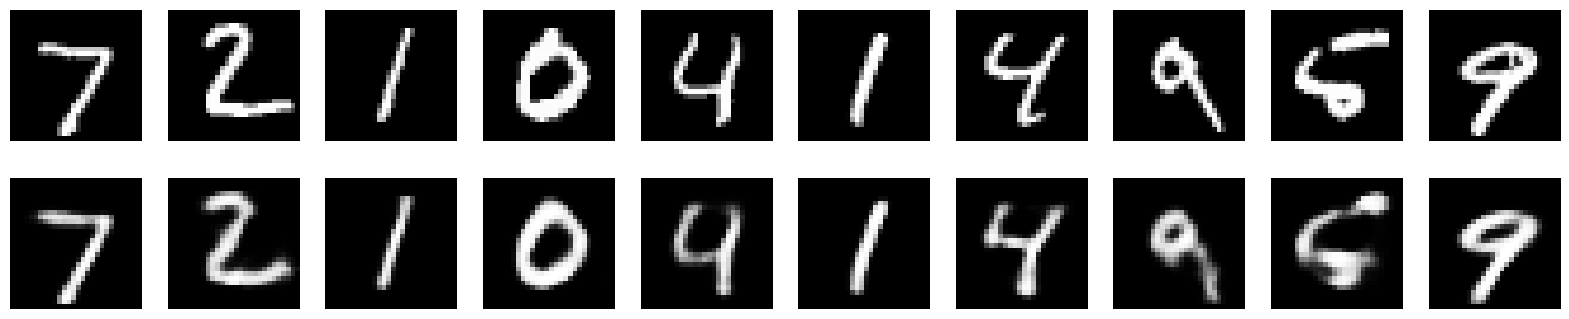

In [10]:
# Visualize original and reconstructed images
import matplotlib.pyplot as plt

# Pick some test images
decoded_imgs = vae.predict(x_test[:10])
plt.figure(figsize=(20, 4))
for i in range(10):
    # Original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.axis("off")
    # Reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()


**Build a Classifier Using the VAE Latent Space**

We now create a simple classifier that uses the latent vector (mean) from the encoder as features.



**Extract Latent Representations**

In [11]:
# Extract the mean vectors of the latent space for all training and test images
# These will serve as features for our classifier
z_mean_train, _, _ = encoder.predict(x_train)
z_mean_test, _, _ = encoder.predict(x_test)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


**Define and Train the Classifier**

In [12]:
classifier = keras.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the classifier using latent features and labels
classifier.fit(z_mean_train, y_train, epochs=20, batch_size=128, validation_data=(z_mean_test, y_test))


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6184 - loss: 1.2275 - val_accuracy: 0.9100 - val_loss: 0.3042
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9151 - loss: 0.2919 - val_accuracy: 0.9303 - val_loss: 0.2258
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9343 - loss: 0.2245 - val_accuracy: 0.9456 - val_loss: 0.1865
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9428 - loss: 0.1911 - val_accuracy: 0.9508 - val_loss: 0.1658
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9506 - loss: 0.1670 - val_accuracy: 0.9568 - val_loss: 0.1518
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9548 - loss: 0.1512 - val_accuracy: 0.9578 - val_loss: 0.1429
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9561 - loss: 0.1454 - val_accuracy: 0.9597 - val_loss: 0.1328
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9585 - loss: 0.1367 - val_accuracy: 0.

#Upload and Classify a Custom Handwritten Digit
**Create an Upload Widget**

You can use the following widget to upload a new image (e.g., a photo of a handwritten digit)

In [16]:
from IPython.display import display
from ipywidgets import FileUpload

upload_widget = FileUpload(accept='image/*', multiple=False)
display(upload_widget)


FileUpload(value={}, accept='image/*', description='Upload')

**Preprocess the Uploaded Image**

This function converts your uploaded image into an MNIST-style image.



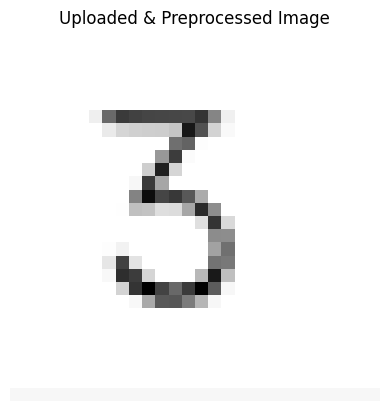

In [17]:
def process_uploaded_image(upload_widget):
    if not upload_widget.value:
        print("No file uploaded yet.")
        return None
    # Extract the first uploaded file
    for filename in upload_widget.value:
        content = upload_widget.value[filename]['content']
        break
    # Open the image, convert to grayscale and resize to 28x28
    image = Image.open(io.BytesIO(content)).convert('L')
    image = image.resize((28, 28))
    # Convert image to numpy array and normalize
    image_np = np.array(image).astype("float32") / 255.
    # Add channel and batch dimensions
    image_np = np.expand_dims(image_np, axis=-1)
    image_np = np.expand_dims(image_np, axis=0)
    return image_np

# Process the uploaded image
uploaded_image = process_uploaded_image(upload_widget)
if uploaded_image is not None:
    plt.imshow(uploaded_image[0].squeeze(), cmap='gray')
    plt.title("Uploaded & Preprocessed Image")
    plt.axis("off")
    plt.show()


**Classify the Uploaded Image**

Pass the preprocessed image through the encoder to get the latent features and then use the classifier to predict the digit.

In [18]:
if uploaded_image is not None:
    # Obtain latent features from the encoder
    z_mean, _, _ = encoder.predict(uploaded_image)
    # Predict using the classifier
    prediction = classifier.predict(z_mean)
    predicted_class = np.argmax(prediction, axis=1)
    print("Predicted digit:", predicted_class[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted digit: 7


In this notebook, we:

- Built a VAE to encode MNIST images into a latent space.
- Added a classifier on the latent representations to predict digit labels.
- Implemented a preprocessing pipeline to convert an uploaded photo of a handwritten digit into an MNIST-style image.
- Successfully predicted the digit from a custom uploaded image.
This assignment demonstrates the combination of unsupervised feature learning (via the VAE) with supervised classification, and it provides a practical workflow for handling image data preprocessing and model integration

**Assignment Overview**

In this assignment, you will implement and experiment with various improvements to the VAE-based digit classification system. The goal is to enhance the classification accuracy of handwritten digits by modifying the existing code. Complete the following tasks and document your findings for each.

**Task 1: Latent Space Experimentation**

- Modify the latent_dim parameter (currently set to 16)
- Test at least three different dimensions (e.g., 8, 32, 64)
- Compare classification accuracy across different latent dimensions
- Create a plot showing the relationship between latent dimension size and classification accuracy

**Task 2: Classifier Architecture Enhancement**

Implement at least two alternative classifier architectures:

- A deeper network with additional hidden layers
- A wider network with more neurons per layer


**Task 3: Regularization Implementation**

- Add dropout layers to the classifier
- Experiment with L1 and/or L2 regularization
- Test different dropout rates (e.g., 0.2, 0.3, 0.5)


**Task 4: VAE Architecture Optimization**

- Replace the dense layers in the encoder/decoder with convolutional/deconvolutional layers
Analyze how these architectural changes affect the latent space and subsequent classification

**Task 5: Loss Function Adjustment**

- Modify the coefficients for reconstruction loss and KL divergence in the VAE
- Test at least three different weightings
- Analyze how these changes affect both reconstruction quality and classification accuracy
- Determine the optimal balance for classification tasks

**Task 6: Training Enhancement**

- Implement a learning rate scheduler
- Increase the number of training epochs
- Add early stopping based on validation performance
- Report on convergence speed and final performance metrics


Each MNIST image is paired with a label (an integer from 0 to 9) indicating the digit it represents.

In the workflow described:

- The VAE is trained in an unsupervised manner on the MNIST images. It learns to compress images into a latent space and then reconstruct them.
- nce the VAE is trained, we use its encoder to extract latent representations (features) for each image.
- The classifier is then trained in a supervised way using these latent features along with the corresponding MNIST labels. It learns to map the latent features to the correct digit classes.